<img src="logo.png">  <br>
* ref : https://www.kaggle.com/c/bike-sharing-demand/overview/evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# -------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis

sns.set()

In [2]:
train = pd.read_csv("./bike-sharing-demand/train.csv")
test = pd.read_csv("./bike-sharing-demand/test.csv")
sub = pd.read_csv("./bike-sharing-demand/sampleSubmission.csv")


In [3]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## target 

#### casual + registered = count
* casual, registered 삭제
* target 불균형 확인

In [7]:
train_cp = train.copy()
print(train_cp.shape)
# casual + registered
train_cp['cr']=train_cp['casual'] + train_cp['registered']
# train_cp[['casual','registered','count','cr' ]].head(20) 
#cr count  : 일치하지않는 레코드
train_cp[train_cp['count'] != train_cp['cr']]['cr'].count()
del train_cp

(10886, 12)


In [8]:
train.drop(['casual', 'registered' ], axis=1, inplace=True)

## Object 타입 처리 

In [9]:
for df in [train, test]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    # df['datetime'] = df['datetime'].astype('datetime64')

    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['week'] = df['datetime'].dt.dayofweek  #월0  ~일6
    
    df.drop(['datetime'], axis=1, inplace=True)  #--- drop

In [10]:
train[(train['year']==2011) & (train['month']==1)]['day'].min(), train[(train['year']==2011) & (train['month']==1)]['day'].max()

(1, 19)

In [11]:
test[(test['year']==2011) & (test['month']==1)]['day'].min(), test[(test['year']==2011) & (test['month']==1)]['day'].max()

(20, 31)

## 1차점수 : 무조건 점수보다 보자(object x,  nan x)

#### 데이터 분리

#### 모델
* 랏쏘 : L1규제 -->  x|w|  중요하지 않은 피쳐의 회귀계수를 0으로 만들수 있다.
* 릿지 : L2규제 -->  xw^2  중요하지 않은 피쳐의 회귀계수를 0에 가깝게 만든다.(피쳐가 없어지진 않는다)
* ElasicNet , XGBoostRegressor , LightGBMRegressor, *TreeRegressor
* LogisticRegressor는 분류모델이다 ******

#### 평가 매트릭스 
* RMSLE  -- np.sqrt(MSLE)
* ‘neg_mean_squared_log_error’   metrics.mean_squared_log_error
* RMSLE = $\sqrt{\frac{1}{n} \sum_{i=1}^n (log(\hat y_i+1) - log(y_i+1))^2 } $ = 
 $\sqrt{\frac{1}{n} \sum_{i=1}^n (\frac{log(\hat y_i+1)}{log(y_i+1)})^2 } $
 ---
* <font color=red>$2^x=3$  -->  $log_2 x=3 $  -->   x=$log_2 3 $</font>
* $log_a b$,  a≠1, a>0, b>0 
* <img src=log.png width=300> 
* <img src=https://t1.daumcdn.net/cfile/tistory/20074646510B224B07 width=180> 
* <font color=red>a가 음수인 경우</font><img src=https://t1.daumcdn.net/cfile/tistory/1623C040510B2A2D25 width=300>
* <font color=red>b가 음수인 경우</font><img src='https://t1.daumcdn.net/cfile/tistory/14420C3D510B36C00B'  width=230>
* <font color=red>b가 0인 경우</font>     $log(y)$는 마이너스 무한대이므로 이를 보정해주기 위해 +1
* <font color=red>$10^x=0$  -->  x=$log (0) $</font>
---
<pre>
<font color='blue'>1) 상대적 Error 측정</font>
  예측값 = 100,    실제값 = 90일 때,    RMSE = 10,    RMSLE = 0.1053
  예측값 = 10,000, 실제값 = 9,000일 때, RMSE = 1,000, RMSLE = 0.1053
<font color='blue'>2) Outlier에 강건</font>
  예측값 = 67, 78, 91,      실제값 = 60, 80, 90일 때,     RMSE = 4.242,   RMSLE = 0.6466
  예측값 = 67, 78, 91, 102, 실제값 = 60, 80, 90, 750일 때 RMSE = 374.724, RMSLE = 1.160
<font color='blue'>3) Under Estimation에 큰 패널티 부여</font>
   Over Estimation(예측값>실제값) , Under Estimation(예측값＜실제값)
   예측값 = 600,   실제값 = 1,000일 때 RMSE = 400, RMSLE = 0.510
   예측값 = 1,400, 실제값 = 1,000일 때 RMSE = 400, RMSLE = 0.33
   <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Logarithms.svg/473px-Logarithms.svg.png width=200>

## 1차 점수확인 : 무조건 점수부터 보자(결측x, object X)

In [12]:
y = train['count']
X = train.drop(['count'], axis=1)

In [13]:
y.shape , X.shape

((10886,), (10886, 13))

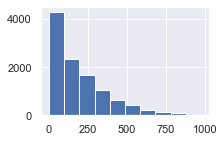

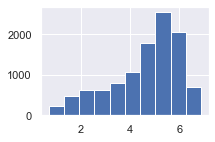

In [14]:
y.hist(figsize=(3,2))
plt.show()

y_log = np.log1p(y)
y_log.hist(figsize=(3,2))
plt.show()

In [15]:
X_train, X_val, y_train, y_val =train_test_split(X, y_log, test_size=0.2, random_state=1414)
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    
    #--------error : Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    #--------로그값y를 지수화해서 원래값으로 복원
    y_val_exp = np.expm1(y_val) 
    pred_exp = np.expm1(pred)
    msle = mean_squared_log_error(y_val_exp, pred_exp)
    rmsle = np.sqrt(msle)
    print(f"{model.__class__.__name__}\t RMSLE:{rmsle:.4f}")    


#  목표점수 ----------- 0.33756  ~ 4.76188
#  pred = abs(bagging_model.predict(X_test))              0.4103   Rank.340
#  score = np.sqrt(mean_squared_log_error(y_test, pred))  0.3408   Rank.2
  

LinearRegression	 RMSLE:0.9976
Ridge	 RMSLE:0.9976
Lasso	 RMSLE:1.0482
ElasticNet	 RMSLE:1.0286
DecisionTreeRegressor	 RMSLE:0.4285
XGBRegressor	 RMSLE:0.2763
LGBMRegressor	 RMSLE:0.2791


## 1차 제출파일 -->  submission.csv --> 오버피팅이 안걸린 약 학습상태

In [16]:
pred = model.predict(test)
pred_exp = np.expm1(pred)
sub['count']  =  np.round(pred_exp).astype(int) 
sub.to_csv("lkh_v0.csv", index=False)

## 공통함수

In [17]:
def my_score(y_val, pred):
    y_val_exp = np.expm1(y_val) 
    pred_exp = np.expm1(pred)
    msle = mean_squared_log_error(y_val_exp, pred_exp)
    rmsle = np.sqrt(msle)
    print(f"{model.__class__.__name__}\t RMSLE:{rmsle:.4f}")   
    return rmsle

In [18]:
models = [LGBMRegressor()]
for model in models:  #X_train, X_val, y_train, y_val
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    my_score(y_val, pred)

LGBMRegressor	 RMSLE:0.2791


## 상관분석

<AxesSubplot:>

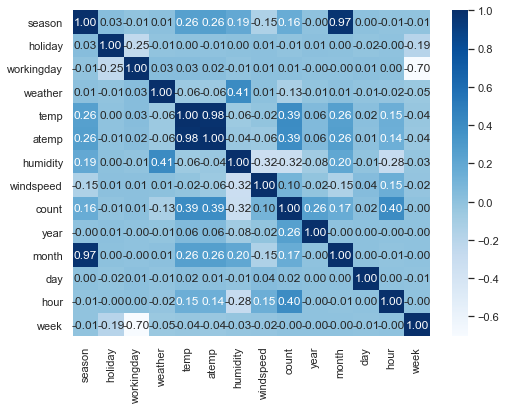

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap='Blues')

* count ==> temp, atemp, hour    
* season & month : 0.97 강하게 다중공선 
* atemp,  temp 강하게 다중공선    
* humidity(습도), weather : 0.41
* week , workingday : -0.70

### 1) season month

In [20]:
train['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [21]:
train['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [22]:
train[['season','month']].value_counts().sort_values()

season  month
1       1        884
        2        901
        3        901
2       4        909
3       9        909
4       10       911
        11       911
2       5        912
        6        912
3       7        912
        8        912
4       12       912
dtype: int64

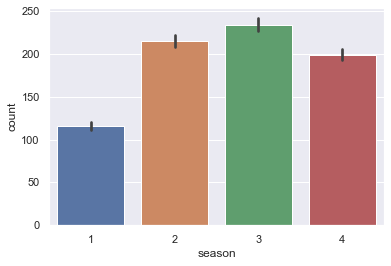

In [23]:
sns.barplot(x='season', y="count", data=train)
plt.show()

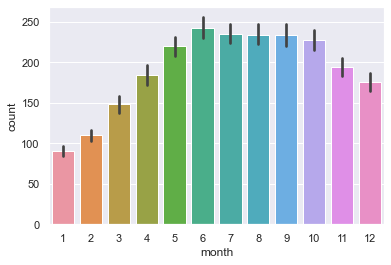

In [24]:
sns.barplot(x='month', y="count", data=train)
plt.show()

In [25]:
pd.crosstab(train['season'], train['month'])

month,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


In [26]:
pd.crosstab(test['season'], test['month'])

month,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,545,440,48,0,0,0,0,0,0,0,0,523
2,0,0,524,528,576,48,0,0,0,0,0,0
3,0,0,0,0,0,480,576,563,144,0,0,0
4,0,0,0,0,0,0,0,0,384,540,526,48


#### 2) week , workingday

In [27]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,week
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5


In [28]:
pd.crosstab(train['week'], train['workingday']).T

week,0,1,2,3,4,5,6
workingday,,,,,,,
0,239,0,24,0,48,1584,1579
1,1312,1539,1527,1553,1481,0,0


In [29]:
# dfdf = pd.DataFrame({"nn":[1,2,3]}, index=['a','b','c'])
# dfdf.index
# dfdf.loc['b']
# dfdf.iloc[1]

#### 방법1) 조건 필터 후 변경 - query

In [30]:
# train['working1_w04'] = 0
# train['working0_w56'] = 0

In [31]:
# idx = train.query( "workingday==1 and week in [0,1,2,3,4]")['working1_w04'].index
# # print(idx, len(idx))
# train['working1_w04'].loc[idx] = 1

# idx = train.query( "workingday==1 and week in [5,6]" )['working1_w04'].index
# # print(idx, len(idx))
# train['working1_w04'].loc[idx] = 0

# train['working1_w04'].value_counts()

#### 방법2) 조건 필터 후 변경 - lambda

In [32]:
x= train[['workingday','week']]
x.head(3)

,workingday,week
0,0,5
1,0,5
2,0,5


In [33]:
train['working1_peak_yn'] = train[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['week']!=5 or x['week']!=6) ], axis=1)
test['working1_peak_yn'] = test[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['week']!=5 or x['week']!=6) ], axis=1)

train['working1_peak_yn'].value_counts()

0    7412
1    3474
Name: working1_peak_yn, dtype: int64

In [34]:
train['working0_peak_yn'] = train[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==0   and  (x['week']==5 or x['week']==6) ], axis=1)
test['working0_peak_yn'] = test[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==0   and  (x['week']==5 or x['week']==6) ], axis=1)
train['working0_peak_yn'].value_counts()

1    7723
0    3163
Name: working0_peak_yn, dtype: int64

In [35]:
train['weekend_yn'] = train[['week']].apply(lambda x : (1,0) [ x['week']==5 or x['week']==6 ], axis=1)
test['weekend_yn'] = test[['week']].apply(lambda x : (1,0) [ x['week']==5 or x['week']==6 ], axis=1)
train['weekend_yn'].value_counts()

1    7723
0    3163
Name: weekend_yn, dtype: int64

#### 3) hour vs. count

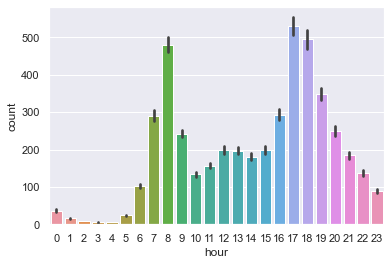

In [36]:
#---- 평일 ['workingday']==1  , 8시  17~18시
sns.barplot(x='hour', y="count", data=train[train['workingday']==1])
plt.show()

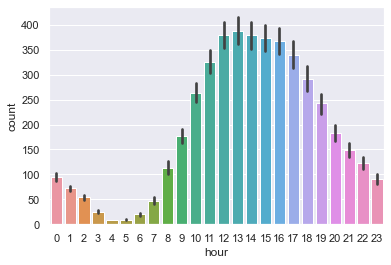

In [37]:
#---- 휴일 ['workingday']==0  ,12~16시
sns.barplot(x='hour', y="count", data=train[train['workingday']==0])
plt.show()

In [38]:

#---- 평일 ['workingday']==1  , 8시  17~18시
train['hour_peak_yn'] = train[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['hour']==8 or 17<=x['hour']<=18) ], axis=1)
#---- 휴일 ['workingday']==0  , 12~16시  10~19시
train['hour_peak_yn'] = train[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==0   and  10<=x['hour']<=19 ], axis=1)


#---- 평일 ['workingday']==1  , 8시  17~18시
test['hour_peak_yn'] = test[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['hour']==8 or 17<=x['hour']<=18) ], axis=1)
#---- 휴일 ['workingday']==0  , 12~16시  10~19시
test['hour_peak_yn'] = test[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==0   and  10<=x['hour']<=19 ], axis=1)


train['hour_peak_yn'].value_counts()




1    9436
0    1450
Name: hour_peak_yn, dtype: int64

## 중간 점수 확인

In [39]:
y_log = np.log1p(train['count'])
X = train.drop(['count'], axis=1)
X_train, X_val, y_train, y_val =train_test_split(X, y_log, test_size=0.2, random_state=1414)

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:  #X_train, X_val, y_train, y_val
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    my_score(y_val, pred)

LinearRegression	 RMSLE:0.9558
Ridge	 RMSLE:0.9558
Lasso	 RMSLE:1.0482
ElasticNet	 RMSLE:1.0286
DecisionTreeRegressor	 RMSLE:0.4148
XGBRegressor	 RMSLE:0.2812
LGBMRegressor	 RMSLE:0.2749


### 4) 온도관련 피쳐 vs. count
* count ==> temp
* windspeed 
* humidity(습도), weather : 0.41

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64


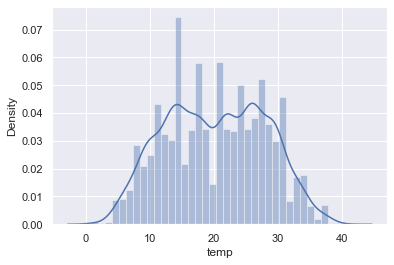

In [40]:
print(train['temp'].describe())
sns.distplot(train['temp'])   #10~30 
plt.show()

count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
25%         47.000000
50%         62.000000
75%         77.000000
max        100.000000
Name: humidity, dtype: float64


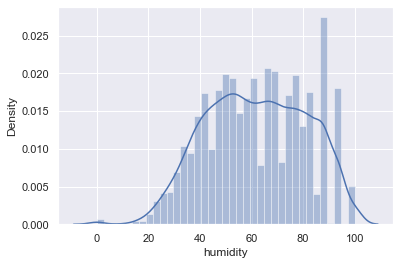

In [41]:
print(train['humidity'].describe())
sns.distplot(train['humidity'])   #30~90 
plt.show()

count    10886.000000
mean         1.418427
std          0.633839
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: weather, dtype: float64


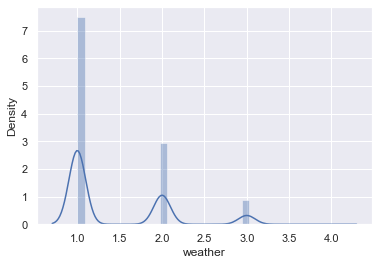

In [42]:
print(train['weather'].describe())
sns.distplot(train['weather'])   #1,2
plt.show()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64


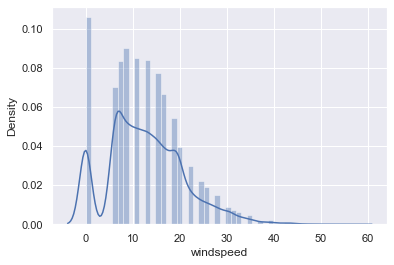

In [43]:
print(train['windspeed'].describe())
sns.distplot(train['windspeed'])   #0 ~24
plt.show()

In [44]:
train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour',
       'week', 'working1_peak_yn', 'working0_peak_yn', 'weekend_yn',
       'hour_peak_yn'],
      dtype='object')

#### 풍속 결측 채우기

In [45]:
# print(train['windspeed'].value_counts())

# def my_fill_windspeed(df): 
#     wind_cols= ['season', 'weather', 'humidity', 'temp', 'atemp','windspeed'] 
#     wind_train  = df.loc[df['windspeed'] != 0][wind_cols] 
#     wind_test = df.loc[df['windspeed'] == 0][wind_cols]
    
#     #wind_train['windspeed'] = wind_train['windspeed'].astype('str') 
    
#     model = RandomForestRegressor() 
#     model.fit(wind_train[wind_cols], wind_train['windspeed']) 
#     pred0 = model.predict(X=wind_test[wind_cols]) 
    
#     wind_test_df = wind_test 
#     wind_train_df = wind_train 
    
#     wind_test_df['windspeed'] = pred0 
#     wind_train_test = wind_train_df.append(wind_test_df) 
#     wind_train_test['windspeed'] = wind_train_test['windspeed'].astype('float') 
#     wind_train_test.reset_index(inplace = True) 
#     wind_train_test.drop('index', inplace = True, axis = 1) 
#     return wind_train_test
# train = my_fill_windspeed(train) 
# test = my_fill_windspeed(test) 

In [46]:
# print(train['windspeed'].describe())
# sns.distplot(train['windspeed'])   #0 ~24
# plt.show()

In [47]:
# def my_fill_windspeed(cp) :
#     wind_train = cp[cp['windspeed']!=0][['season','weather', 'temp', 'atemp', 'humidity', 'windspeed']]
#     wind_test = cp[cp['windspeed']==0][['season','weather', 'temp', 'atemp', 'humidity', 'windspeed']]

#     y_wind_train8답안지 = wind_train['windspeed']
#     X_wind_train8문제지 = wind_train.drop(['windspeed'], axis=1)
#     X_wind_test2답안지 = wind_test['windspeed']
#     y_wind_test2문제지 = wind_test.drop(['windspeed'], axis=1)

#     wind_model = LGBMRegressor()
#     wind_model.fit(X_wind_train8문제지, y_wind_train8답안지)
#     pred = wind_model.predict(y_wind_test2문제지)
#     X_wind_test2답안지 = np.round(pred,5)
    
    
#     cp = wind_train.append(wind_test)
    
#     cp.reset_index(inplace=True)
#     cp.drop("index", inplace=True, axis=1)
#     return cp

# train = my_fill_windspeed(train)    
# test = my_fill_windspeed(test)    

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64


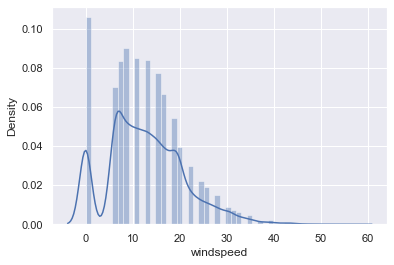

In [48]:
print(train['windspeed'].describe())
sns.distplot(train['windspeed'])   #0 ~24
plt.show()

In [49]:
# --------------------------------------
# train['temp']       #10~30 
# train['humidity']   #30~90 
# train['weather']    #1,2
# train['windspeed']  #0~24
# --------------------------------------
# weather - 날씨 
#   - 1: 맑음, 대체로 흐림, 일부 흐림 
#   - 2: 안개 + 흐림, 안개 + 깨진 구름, 안개 + 구름이 거의 없음, 안개 
#   - 3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름 
#   - 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개

train['weather_peak_yn'] = train[['temp','humidity','weather','windspeed']].apply(lambda x : (1,0) [ 10<=x['temp']<=30 and  
                                                                                     30<=x['humidity']<=90 and 
                                                                                     x['weather'] in [1,2] and
                                                                                     0<=x['windspeed']<=24 ], axis=1)


test['weather_peak_yn'] = test[['temp','humidity','weather','windspeed']].apply(lambda x : (1,0) [ 10<=x['temp']<=30 and  
                                                                                     30<=x['humidity']<=90 and 
                                                                                     x['weather'] in [1,2] and
                                                                                     0<=x['windspeed']<=24 ], axis=1)


train['weather_peak_yn'].value_counts()

0    6506
1    4380
Name: weather_peak_yn, dtype: int64

### 5) holiday
* 주어진 데이터 이외의 추가 휴일은 고려하지 않음

In [50]:
# train.loc[pd.datetime(2011, 6, 19)]['holiday']
train[train['holiday']==1][['workingday','year','month','day']].value_counts()

workingday  year  month  day
0           2011  1      17     24
                  4      15     24
                  7      4      24
                  9      5      24
                  10     10     24
                  11     11     24
            2012  1      16     24
                  4      16     24
                  7      4      24
                  9      3      24
                  10     8      24
                  11     12     24
                  1      2      23
dtype: int64

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            10886 non-null  int64  
 1   holiday           10886 non-null  int64  
 2   workingday        10886 non-null  int64  
 3   weather           10886 non-null  int64  
 4   temp              10886 non-null  float64
 5   atemp             10886 non-null  float64
 6   humidity          10886 non-null  int64  
 7   windspeed         10886 non-null  float64
 8   count             10886 non-null  int64  
 9   year              10886 non-null  int64  
 10  month             10886 non-null  int64  
 11  day               10886 non-null  int64  
 12  hour              10886 non-null  int64  
 13  week              10886 non-null  int64  
 14  working1_peak_yn  10886 non-null  int64  
 15  working0_peak_yn  10886 non-null  int64  
 16  weekend_yn        10886 non-null  int64 

In [52]:
train.shape, test.shape

((10886, 19), (6493, 18))

## 중간 점수 확인

In [53]:
y_log = np.log1p(train['count'])
X = train.drop(['count'], axis=1)
X_train, X_val, y_train, y_val =train_test_split(X, y_log, test_size=0.2, random_state=1414)

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:  #X_train, X_val, y_train, y_val
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    my_score(y_val, pred)

LinearRegression	 RMSLE:0.9529
Ridge	 RMSLE:0.9529
Lasso	 RMSLE:1.0482
ElasticNet	 RMSLE:1.0286
DecisionTreeRegressor	 RMSLE:0.4192
XGBRegressor	 RMSLE:0.2739
LGBMRegressor	 RMSLE:0.2730


### 원핫인코딩

##### 1) 카테고리성 피쳐 선별

In [54]:
train_test = pd.concat([train, test], axis=0)
print(train_test.shape)
print(train_test.columns.values.tolist())

for col in train_test.columns :
    print(col, train_test[col].nunique(), train_test[col].unique()[:10])

(17379, 19)
['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour', 'week', 'working1_peak_yn', 'working0_peak_yn', 'weekend_yn', 'hour_peak_yn', 'weather_peak_yn']
season 4 [1 2 3 4]
holiday 2 [0 1]
workingday 2 [0 1]
weather 4 [1 2 3 4]
temp 50 [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4 ]
atemp 65 [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455]
humidity 89 [81 80 75 86 76 77 72 82 88 87]
windspeed 30 [ 0.      6.0032 16.9979 19.0012 19.9995 12.998  15.0013  8.9981 11.0014
 22.0028]
count 822 [16. 40. 32. 13.  1.  2.  3.  8. 14. 36.]
year 2 [2011 2012]
month 12 [ 1  2  3  4  5  6  7  8  9 10]
day 31 [ 1  2  3  4  5  6  7  8  9 10]
hour 24 [0 1 2 3 4 5 6 7 8 9]
week 7 [5 6 0 1 2 3 4]
working1_peak_yn 2 [1 0]
working0_peak_yn 2 [0 1]
weekend_yn 2 [0 1]
hour_peak_yn 2 [1 0]
weather_peak_yn 2 [1 0]


In [55]:
oh_cols = ['season', 'weather', 'year', 'month', 'day', 'hour', 'week']
for col in oh_cols:
    oh_df = pd.get_dummies(train_test[col], prefix=col)
    train_test = pd.concat([train_test, oh_df], axis=1)  
    
train = train_test[train_test['count'].notna()]
test = train_test[train_test['count'].isna()]
test.drop(['count'], axis=1, inplace=True)

In [56]:
train.shape, test.shape

((10886, 103), (6493, 102))

## 중간 점수 확인

In [57]:
y_log = np.log1p(train['count'])
X = train.drop(['count'], axis=1)
X_train, X_val, y_train, y_val =train_test_split(X, y_log, test_size=0.2, random_state=1414)

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:  #X_train, X_val, y_train, y_val
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    my_score(y_val, pred)

LinearRegression	 RMSLE:0.5791
Ridge	 RMSLE:0.5787
Lasso	 RMSLE:1.0482
ElasticNet	 RMSLE:1.0286
DecisionTreeRegressor	 RMSLE:0.4216
XGBRegressor	 RMSLE:0.2815
LGBMRegressor	 RMSLE:0.2767


### 3) year
* 2011 0  , 2012  1  --> OnehotEncoding 
* 또는
* log1p()

In [58]:
# train['year'] = np.log1p(train['year'])
# test['year'] = np.log1p(test['year'])

### 4) temp, atemp -- PCA

#### 스케일링

#### X,y 타겟분리

In [59]:
y_log = np.log1p(train['count'] )
train = train.drop(['count'], axis=1) 

In [60]:
scale_cols = ['temp', 'atemp', 'humidity', 'windspeed']
scaler = StandardScaler()
scaler.fit(train[scale_cols])
train_scaler = scaler.transform(train[scale_cols])
test_scaler = scaler.transform(test[scale_cols])

In [61]:
train_scaler[:5]

array([[-1.33366069, -1.09273697,  0.99321305, -1.56775367],
       [-1.43890721, -1.18242083,  0.94124921, -1.56775367],
       [-1.43890721, -1.18242083,  0.94124921, -1.56775367],
       [-1.33366069, -1.09273697,  0.68142998, -1.56775367],
       [-1.33366069, -1.09273697,  0.68142998, -1.56775367]])

In [62]:
train.drop(scale_cols, axis=1, inplace=True)
test.drop(scale_cols, axis=1, inplace=True)

In [63]:
train_scaler_df = pd.DataFrame(train_scaler, columns = scale_cols)
test_scaler_df = pd.DataFrame(test_scaler, columns = scale_cols)
train = pd.concat([train, train_scaler_df], axis=1)
test = pd.concat([test, test_scaler_df], axis=1)

#### PCA

In [64]:
train[['temp','atemp']].head()

,temp,atemp
0,-1.333661,-1.092737
1,-1.438907,-1.182421
2,-1.438907,-1.182421
3,-1.333661,-1.092737
4,-1.333661,-1.092737


In [65]:
pca = PCA(n_components=1)
pca.fit(train[['temp','atemp']])
train['PCA_temp_atemp'] = pca.transform(train[['temp','atemp']])
pca.fit(test[['temp','atemp']])
test['PCA_temp_atemp'] = pca.transform(test[['temp','atemp']])


print(pca.explained_variance_ratio_)


[0.99596815]


In [66]:
train.drop(['temp','atemp'], axis=1, inplace=True)
test.drop(['temp','atemp'], axis=1, inplace=True)

In [67]:
train.head()

,season,holiday,workingday,weather,year,month,day,hour,week,working1_peak_yn,...,week_0,week_1,week_2,week_3,week_4,week_5,week_6,humidity,windspeed,PCA_temp_atemp
0,1,0,0,1,2011,1,1,0,5,1,...,0,0,0,0,0,1,0,0.993213,-1.567754,1.715722
1,1,0,0,1,2011,1,1,1,5,1,...,0,0,0,0,0,1,0,0.941249,-1.567754,1.853559
2,1,0,0,1,2011,1,1,2,5,1,...,0,0,0,0,0,1,0,0.941249,-1.567754,1.853559
3,1,0,0,1,2011,1,1,3,5,1,...,0,0,0,0,0,1,0,0.681430,-1.567754,1.715722
4,1,0,0,1,2011,1,1,4,5,1,...,0,0,0,0,0,1,0,0.681430,-1.567754,1.715722


In [68]:
train.shape, test.shape, y_log.shape

((10886, 101), (6493, 101), (10886,))

## 중간 점수 확인

In [69]:
X_train, X_val, y_train, y_val =train_test_split(train, y_log, test_size=0.2, random_state=1414)

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:  #X_train, X_val, y_train, y_val
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    my_score(y_val, pred)

LinearRegression	 RMSLE:0.5790
Ridge	 RMSLE:0.5788
Lasso	 RMSLE:1.1620
ElasticNet	 RMSLE:1.1275
DecisionTreeRegressor	 RMSLE:0.4142
XGBRegressor	 RMSLE:0.2807
LGBMRegressor	 RMSLE:0.2780


In [70]:
train.shape, y_log.shape, test.shape

((10886, 101), (10886,), (6493, 101))

## XGBRegressor	 RMSLE:0.2763 - submission.csv 제출
* X_train, X_val, y_train, y_val =train_test_split(train, y_log, test_size=0.2, random_state=1414)
* <font color='red'><b>train.shape, y_log.shape, test.shape ((10886, 101), (10886,), (6493, 101))</b></font>
---
*  목표점수 ----------- 0.33756  ~ 4.76188
*   pred = abs(bagging_model.predict(X_test))              0.4103   Rank.340
*   score = np.sqrt(mean_squared_log_error(y_test, pred))  0.3408   Rank.2

In [71]:
test[['year','month','day','hour']].tail()

,year,month,day,hour
6488,2012,12,31,19
6489,2012,12,31,20
6490,2012,12,31,21
6491,2012,12,31,22
6492,2012,12,31,23


In [72]:
sub.tail()

,datetime,count
6488,2012-12-31 19:00:00,242
6489,2012-12-31 20:00:00,155
6490,2012-12-31 21:00:00,129
6491,2012-12-31 22:00:00,97
6492,2012-12-31 23:00:00,57


In [73]:
models = [LGBMRegressor()]
for model in models:  #X_train, X_val, y_train, y_val
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    my_score(y_val, pred)

LGBMRegressor	 RMSLE:0.2780


In [74]:
# 모델은 학습시 집 가격을 로그화(12400  --> 5.3)  데이터로 학습되 있는 상태
model.fit(train, y_log) 
pred = model.predict(test)
print("np.log1p() 예측답안", pred[:5])   #[3.10501942 2.40850568 1.81049886 1.48577173 1.54803569]

# np.log  np.log1p lus <-- --> np.expm1 inus
pred_exp = np.expm1(pred)
print("np.expm1() 예측답안", pred_exp[:5])  

# RMSLE = Under Estimation(예측값＜실제값) 에 큰 패널티 부여  
print("np.round() 최종답안", np.round(pred_exp).astype(int))
sub['count']  =  np.round(pred_exp).astype(int) 

sub.head()

np.log1p() 예측답안 [3.10501942 2.40850568 1.81049886 1.48577173 1.54803569]
np.expm1() 예측답안 [21.30965215 10.11733592  5.11349647  3.4183739   3.70222449]
np.round() 최종답안 [ 21  10   5 ... 305 193 104]


,datetime,count
0,2011-01-20 00:00:00,21
1,2011-01-20 01:00:00,10
2,2011-01-20 02:00:00,5
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,4


In [75]:
# pred = model.predict(test)
# pred_exp = np.expm1(pred)
# sub['count']  =  np.round(pred_exp).astype(int) 
sub.to_csv("lkh_v1.csv", index=False)

## 회귀모델 boost 계열 모델 --> 엄청난 오버피팅이 문제
* 규제 강화
* 모델 하이퍼파라미터 튜닝
* 데이터 학습량 늘리기
* 연속형 피쳐 데이터 바인딩
* train / test 피쳐별 분포 비교 --> 원인이 되는 피쳐 아웃라이어 처리
* 외도 심한 피처 정규화

In [76]:
cols = train.columns
cols_len = len(cols)
train_arr = []
test_arr = []
diff_arr = []
for i, col in enumerate(cols):
#     {"col":train.columns, "train_skew":skew(train[col]), "test_skew":skew(test[col]), "diff":skew(train[col])-skew(test[col]) })
#     print(col, skew(train[col]))

df = pd.DataFrame(
df.head()
    

IndentationError: expected an indented block (Temp/ipykernel_6168/4261879951.py, line 10)

In [ ]:
cols = train.columns
cols_len = len(cols)
f,ax=plt.subplots( int(np.ceil(cols_len/4)) ,4,figsize=(18, 4*int(np.ceil(cols_len/4))))

for i, col in enumerate(cols):
    c = i % 4
    r = i // 4
    sns.histplot(data=train, x=col, kde=True,  ax=ax[r][c])
    sns.histplot(data=test, x=col,  kde=True, color = 'green', ax=ax[r][c])
plt.show()

    

### 구간화(바인딩)
* dict - map()
* lambda & def - apply
* cut(), qcut()

In [ ]:
# train_test = pd.concat([train, test], axis=0)
# train_test['temp'].hist()
# plt.show()
# #------------------------------------
# train_test.loc[train_test['temp']<=0, 'temp_band1'] = 1
# train_test.loc[(train_test['temp']>0) & (train_test['temp']<=13), 'temp_band1'] = 2
# train_test.loc[(train_test['temp']>13) & (train_test['temp']<=20), 'temp_band1'] = 3
# train_test.loc[(train_test['temp']>20) & (train_test['temp']<=27), 'temp_band1'] = 4
# train_test.loc[(train_test['temp']>27) & (train_test['temp']<=45), 'temp_band1'] = 5
# train_test.loc[train_test['temp']>45, 'temp_band1'] = 6

# train_test['temp_band1'] = train_test['temp_band1'].astype('int')
# #------------------------------------
# # 수치비교(부등호) 안되기때문에 현재 상황에서는 사용 불가 ==> 단일성 값의 경우에 사용
# # dict = {"A":1, "B":2} 
# # train_test['temp_band2'] =train_test['temp'].map(dict) 
# #------------------------------------

# def temp_bind(x):
#     temp_band1 = 0
#     if x<=0:
#         temp_band1 = 1
#     elif (x>0) & (x<=13):
#         temp_band1 = 2
#     elif (x>13) & (x<=20):
#         temp_band1 = 3
#     elif (x>20) & (x<=27):
#         temp_band1 = 4
#     elif (x>27) & (x<=45):
#         temp_band1 = 5
#     else:
#         temp_band1 = 6
#     return temp_band1
# train_test['temp_band2'] = train_test['temp'].apply(lambda x: temp_bind(x))
# #------------------------------------
# train_test['temp_band3'] =pd.cut(train_test['temp'], bins=[-100,0,13,20,27,45,100], labels=[1,2,3,4,5,6])
# #------------------------------------
# train_test[['temp','temp_band1','temp_band2','temp_band3']].head(20)
